### KEGG API ACCESS

---

Natalia García Sánchez
16/11/2023

Acceso programatico a bbdd KEGG, que recoge información desde el punto de vista de rutas metabólicas - gen.

Objetivo: conseguir genes / homólogos implicados en la **ruta del metabolismo del azufre** - relacionar con genes diferencialmente expresados obtenidos de los resultados de transcriptómica


cargado de librerías

In [5]:
# Data retrieval and processing
import requests
import pandas as pd


# Standard library packages
import io
import os

# IMG display packages
from PIL import Image
from io import BytesIO
from IPython.display import display # to display images
import matplotlib.pyplot as plt


# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
#from Bio.Graphics.KGML_vis import KGMLCanvas

# https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html

import helper functions

In [34]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# Some code to return a Pandas dataframe, given tabular text
def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

# Some code to return a Pandas dataframe, given tabular text
def to_df2(result):
    return pd.DataFrame(result)

In [ ]:
# kegg pathway modules https://www.genome.jp/brite/ko00002

### Buscamos la cadena "sulfuro" para conseguir todos los módulos de rutas metabólicas directamente relacionadas con este

In [ ]:
result = REST.kegg_list("pathway", "").read()
result = result.split("\n")
print(result)

In [150]:
result = REST.kegg_link("pathway", "ec:2.7.11.1").read()
result = result.split("\n")
print(result)

['ec:2.7.11.1\tpath:map05170', '']


In [39]:
result = REST.kegg_find("module", "sulfur").read()
result = result.split("\n")
result = list(map(lambda x: x.replace("md:", "").split("\t"), result))
module = df = to_df2(result).dropna()
module

,0,1
0,M00613,Anoxygenic photosynthesis in green nonsulfur b...
1,M00614,Anoxygenic photosynthesis in green sulfur bact...
2,M00616,Sulfate-sulfur assimilation


In [40]:
# read all info related with patway
result_sm = REST.kegg_get("M00616").read()
print(result_sm)


ENTRY       M00616            Signature Module
NAME        Sulfate-sulfur assimilation
DEFINITION  (K02048,K23163)+K02046+K02047+K02045 M00176
ORTHOLOGY   K02048  cysP; sulfate transport system substrate-binding protein
            K02046  cysU; sulfate transport system permease protein
            K02047  cysW; sulfate transport system permease protein
            K02045  cysA; sulfate transport system ATP-binding protein
            (M00176  Assimilatory sulfate reduction, sulfate => H2S)
            K13811,K00958,K00955+K00957,K00956  sulfate adenylyltransferase
            K13811,K00860,K00955  adenylylsulfate kinase
            K00390  phosphoadenosine phosphosulfate reductase
            K00380+K00381  sulfite reductase (NADPH)
            K00392  sulfite reductase (ferredoxin)
CLASS       Signature modules; Module set; Metabolic capacity
///



In [42]:
# read all info related with patway
result_sm = REST.kegg_get("M00176").read()
print(result_sm)


ENTRY       M00176            Pathway   Module
NAME        Assimilatory sulfate reduction, sulfate => H2S
DEFINITION  (((K13811,K00958+K00860,K00955+K00957,K00956+K00957+K00860) K00390),(K13811 K05907)) (K00380+K00381,K00392)
ORTHOLOGY   K13811,K00958,K00955+K00957,K00956  sulfate adenylyltransferase [EC:2.7.7.4] [RN:R00529]
            K13811,K00860,K00955  adenylylsulfate kinase [EC:2.7.1.25] [RN:R00509]
            K00390  phosphoadenosine phosphosulfate reductase [EC:1.8.4.8] [RN:R02021]
            K05907  adenylyl-sulfate reductase (glutathione) [EC:1.8.4.9] [RN:R05717]
            K00380+K00381  sulfite reductase (NADPH) [EC:1.8.1.2] [RN:R00858]
            K00392  sulfite reductase (ferredoxin) [EC:1.8.7.1] [RN:R00859]
CLASS       Pathway modules; Energy metabolism; Sulfur metabolism
PATHWAY     map00920  Sulfur metabolism
            map01100  Metabolic pathways
            map01120  Microbial metabolism in diverse environments
REACTION    R00529  C00059 -> C00224
            

### Buscamos la cadena "sulfuro" para conseguir todas las rutas metabólicas directamente relacionadas con este

In [146]:
# Get reactions involved with sulfur
result = REST.kegg_find("pathway", "sulfur").read()
result = result.split("\n")
result = list(map(lambda x: x.replace("path:map", "bna").split("\t"), result))
result

[['bna00920', 'Sulfur metabolism'], ['bna04122', 'Sulfur relay system'], ['']]

overview ruta

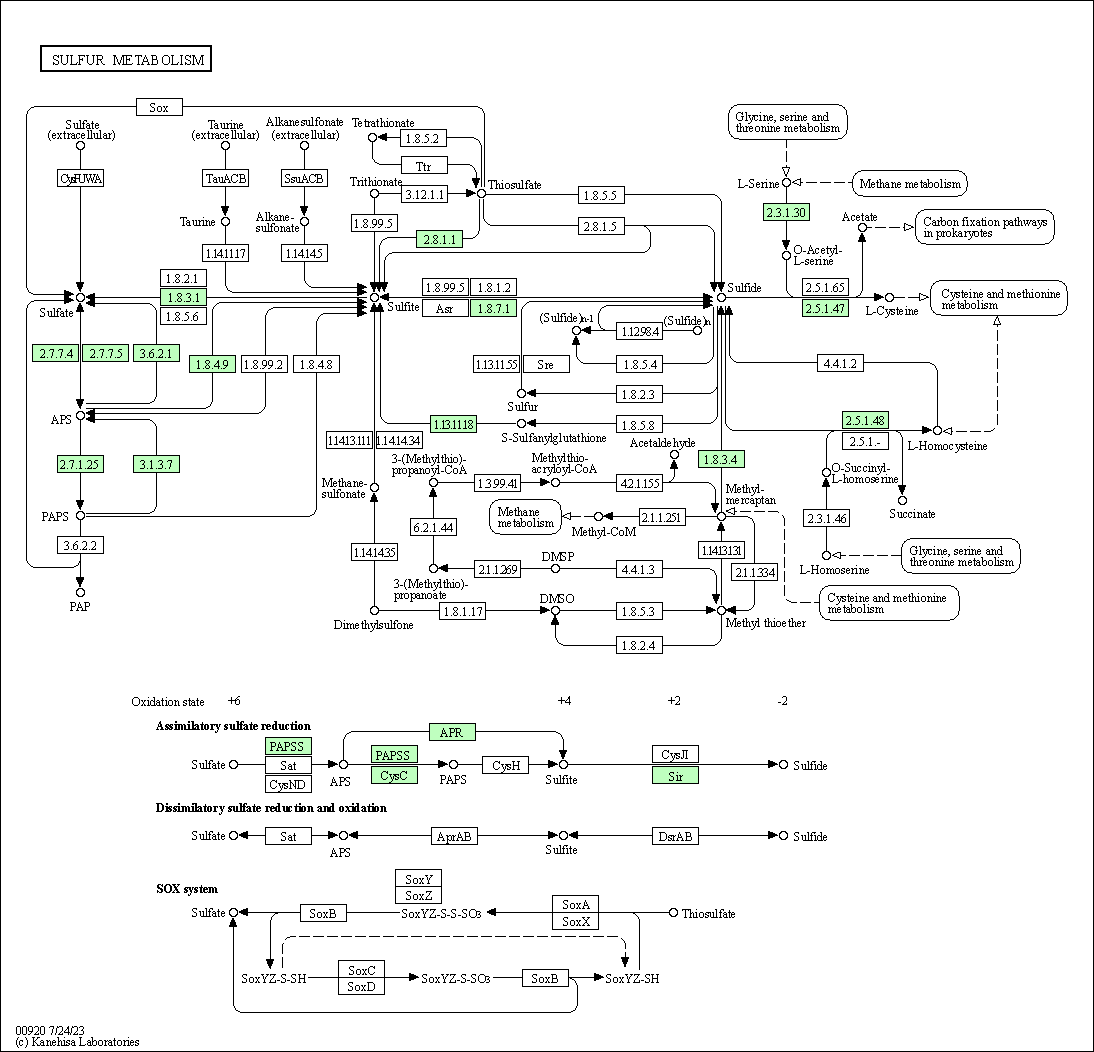

In [25]:
# Get map of sulfur metabolism in Brassica napus
result = REST.kegg_get("bna00920", "image").read()
# Image(result)

img = Image.open(BytesIO(result))
display(img)

# Display image and save image
# img.show()
# img.save('result.png')

In [24]:
path_df = pd.DataFrame(result, columns=["code", "Description"])
path_df = path_df.dropna()

#### Recopilación y parseado de toda la información relativa a la ruta metabólica *Sulfur metabolism, bna00920*

search all genes from kegg database for term 009020 bna

In [99]:
# Get entry information for all pathways - filter gene and pathway information
df_mapsg = pd.DataFrame(columns=["Description", "KO_ortholog_id", "EC_enzyme_accession", "GID"]) # optional : add pathway
df_related_pathways = pd.DataFrame(columns=["code", "Description"])
df_goterms = pd.DataFrame(columns=["GOcode"])

# get gene, pathway, GO term information per pathway
for pathway in path_df["code"].values.tolist():
    
    # read all info related with patway
    result_sp = REST.kegg_get(pathway).read()
    #print(result_sp)
    
    # parse to get gene
    genes_sp = result_sp.split("GENE        ", )[1].split("\nCOMPOUND    ")[0].split("\n            ")
    
    # get identifiers, append to gene df
    genes_sp_id = list(map(lambda x: x[0:9],genes_sp))
    descr_id = list(map(lambda x: x[11:],genes_sp))
    descr_id_l = list(map(lambda x: x.split("["), descr_id))
    descr_id_l = list(map(lambda x: list(map(lambda i: i.replace("] ", "").replace("]", "").replace("KO:", "").replace("EC:", ""), x)), descr_id_l))
    genes_path = list(map(lambda x, y: x+[y], descr_id_l,genes_sp_id )) # optional : add pathway
    df_mapsg = pd.concat((df_mapsg, pd.DataFrame(genes_path, columns=["Description", "KO_ortholog_id", "EC_enzyme_accession", "GID"])), ignore_index=True) # optional : add pathway
    
    # get related pathways jic
    pathways_interest = result_sp.split("REL_PATHWAY ", )[1].split("\nKO_PATHWAY  ")[0].split("\n            ")
    pathways_interest = list(map(lambda x: x.split("  "), pathways_interest))
    df_related_pathways = pd.concat((df_related_pathways, pd.DataFrame(pathways_interest, columns=["code", "Description"])), ignore_index=True)
    
    # get related GO terms
    if "DBLINKS" in result_sp:
        GO_sp = result_sp.split("DBLINKS     ", )[1].split("GO:")[1].split("\n")[0].split(" ")
        GO_sp = list(map(lambda x: "GO:"+x, GO_sp))
        df_goterms = pd.concat((df_goterms, pd.DataFrame(GO_sp, columns=["GOcode"])), ignore_index=True)
        
df_goterms = df_goterms.drop(df_goterms[df_goterms["GOcode"]=="GO:"].index)

In [82]:
df_related_pathways.drop_duplicates()

,code,Description
0,bna00260,"Glycine, serine and threonine metabolism"
1,bna00270,Cysteine and methionine metabolism
3,bna00730,Thiamine metabolism
4,bna00790,Folate biosynthesis
5,bna04120,Ubiquitin mediated proteolysis


In [86]:
df_mapsg.drop_duplicates()

,Description,KO_ortholog_id,EC_enzyme_accession,GID
0,"ATP sulfurylase 4, chloroplastic",K13811,2.7.7.4 2.7.1.25,106410303
1,"ATP-sulfurylase 3, chloroplastic",K13811,2.7.7.4 2.7.1.25,106369188
2,ATP sulfurylase 2,K13811,2.7.7.4 2.7.1.25,106346981
3,"ATP sulfurylase 1, chloroplastic-like isoform X2",K13811,2.7.7.4 2.7.1.25,106357712
4,ATP sulfurylase 2,K13811,2.7.7.4 2.7.1.25,106347063
...,...,...,...,...
157,LOW QUALITY PROTEIN: molybdopterin synthase ca...,K03635,2.8.1.12,106391819
158,"GTP 3',8-cyclase, mitochondrial-like",K03639,4.1.99.22,106387983
159,"GTP 3',8-cyclase, mitochondrial",K03639,4.1.99.22,106437709
160,"cyclic pyranopterin monophosphate synthase, mi...",K03637,4.6.1.17,106377366


In [104]:
df_mapsg.to_excel("C:\\Users\\naata\\Downloads\\metabo_sulf_genes.xlsx")

In [102]:
df_goterms

,GOcode
1,GO:0006790


In [139]:
requestURL = "https://www.ebi.ac.uk/QuickGO/services/annotation/search?includeFields=goName&selectedFields=geneProductId&selectedFields=symbol&selectedFields=evidenceCode&taxonId=3708&goId=GO:0006790"


r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.json()
df_go_specific_genes = pd.DataFrame(responseBody["results"])
colnames = df_go_specific_genes.columns[:].tolist()
res_all = pd.DataFrame(columns=colnames)


for page in range(1, (responseBody["numberOfHits"] // 25)+2):
    requestURL = f"https://www.ebi.ac.uk/QuickGO/services/annotation/search?includeFields=goName&selectedFields=geneProductId&selectedFields=symbol&selectedFields=evidenceCode&taxonId=3708&goId=GO:0006790&page={page}"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()

    responseBody = r.json()
    res_all = pd.concat((res_all, pd.DataFrame(responseBody["results"])), ignore_index=True)



In [140]:
res_all

,id,geneProductId,qualifier,goId,goName,goEvidence,goAspect,evidenceCode,reference,withFrom,taxonId,taxonName,assignedBy,extensions,targetSets,symbol,date,synonyms,name
0,UniProtKB:A0A078C5F6!264431593,UniProtKB:A0A078C5F6,involved_in,GO:0006790,sulfur compound metabolic process,IBA,biological_process,ECO:0000318,PMID:21873635,"[{'connectedXrefs': [{'db': 'PANTHER', 'id': '...",3708,None,GO_Central,None,None,BnaA09g35930D,20200219,None,None
1,UniProtKB:A0A078F093!375551365,UniProtKB:A0A078F093,involved_in,GO:0006535,cysteine biosynthetic process from serine,IEA,biological_process,ECO:0000256,GO_REF:0000002,"[{'connectedXrefs': [{'db': 'InterPro', 'id': ...",3708,None,InterPro,None,None,BnaC03g47870D,20230911,None,None
2,UniProtKB:A0A078F093!375561665,UniProtKB:A0A078F093,involved_in,GO:0019344,cysteine biosynthetic process,IEA,biological_process,ECO:0007322,GO_REF:0000041,"[{'connectedXrefs': [{'db': 'UniPathway', 'id'...",3708,None,UniProt,None,None,BnaC03g47870D,20230911,None,None
3,UniProtKB:A0A078F344!279293408,UniProtKB:A0A078F344,involved_in,GO:0016226,iron-sulfur cluster assembly,IBA,biological_process,ECO:0000318,PMID:21873635,"[{'connectedXrefs': [{'db': 'PANTHER', 'id': '...",3708,None,GO_Central,None,None,BnaA07g24680D,20170228,None,None
4,UniProtKB:A0A078F3D6!477194040,UniProtKB:A0A078F3D6,involved_in,GO:0051923,sulfation,IBA,biological_process,ECO:0000318,PMID:21873635,"[{'connectedXrefs': [{'db': 'FB', 'id': 'FBgn0...",3708,None,GO_Central,None,None,BnaC06g15020D,20221007,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,UniProtKB:Q93Y50!838778852,UniProtKB:Q93Y50,involved_in,GO:2001295,malonyl-CoA biosynthetic process,IEA,biological_process,ECO:0007322,GO_REF:0000041,"[{'connectedXrefs': [{'db': 'UniPathway', 'id'...",3708,None,UniProt,None,None,Q93Y50,20230911,None,None
1356,UniProtKB:Q96349!834604060,UniProtKB:Q96349,involved_in,GO:0000103,sulfate assimilation,IEA,biological_process,ECO:0000256,GO_REF:0000002,"[{'connectedXrefs': [{'db': 'InterPro', 'id': ...",3708,None,InterPro,None,None,LSC680,20230911,None,None
1357,UniProtKB:Q9FEH8!200684090,UniProtKB:Q9FEH8,involved_in,GO:2001295,malonyl-CoA biosynthetic process,IEA,biological_process,ECO:0007322,GO_REF:0000041,"[{'connectedXrefs': [{'db': 'UniPathway', 'id'...",3708,None,UniProt,None,None,acc2.1,20230911,None,None
1358,UniProtKB:Q9FNT7!890152143,UniProtKB:Q9FNT7,involved_in,GO:2001295,malonyl-CoA biosynthetic process,IEA,biological_process,ECO:0007322,GO_REF:0000041,"[{'connectedXrefs': [{'db': 'UniPathway', 'id'...",3708,None,UniProt,None,None,acc1.2,20230911,None,None


In [141]:
df_DEG_ = pd.read_csv("C:\\Users\\naata\\Downloads\\deg_sara.csv")

In [145]:
df_final = res_all.merge(df_DEG_, on ="symbol", how="inner")
df_final.to_excel("C:\\Users\\naata\\Downloads\\DEG_annotated.xlsx", index=None)

convert kegg gene id to ncbi entrez gene id

/conv/ncbi-geneid/eco	  	opposite direction
/conv/ncbi-proteinid/hsa:10458+ece:Z5100	  	conversion from KEGG ID to NCBI ProteinID
/conv/genes/ncbi-geneid:948364	  	conversion from NCBI GeneID to KEGG ID when the organism code is not known

In [105]:
#response = REST.kegg_conv("ncbi-geneid", "bna", option=None).read()
#response = REST.kegg_conv("ncbi-proteinid", "bna", option=None).read()
response = REST.kegg_conv("uniprot", "bna", option=None).read()

In [107]:
map_uniprot = list(map(lambda x: x.split("\t"), response.replace("up:", "").replace("bna:", "").split("\n")))
map_df = to_df2(map_uniprot)
map_df = map_df.rename(columns={map_df.columns[0]:"GID", map_df.columns[1]:"Uniprot"})
map_df

,GID,Uniprot
0,106345163,A0A078IIQ8
1,106345165,A0A816U6E2
2,106345166,A0A078HIZ4
3,106345167,A0A816JBK4
4,106345170,A0A078JZ69
...,...,...
26692,4237949,Q6YSM0
26693,4237950,Q6YSL2
26694,4237951,Q6YSR8
26695,4237970,P68160


In [153]:
df_mapsg

,Description,KO_ortholog_id,EC_enzyme_accession,GID
0,"ATP sulfurylase 4, chloroplastic",K13811,2.7.7.4 2.7.1.25,106410303
1,"ATP-sulfurylase 3, chloroplastic",K13811,2.7.7.4 2.7.1.25,106369188
2,ATP sulfurylase 2,K13811,2.7.7.4 2.7.1.25,106346981
3,"ATP sulfurylase 1, chloroplastic-like isoform X2",K13811,2.7.7.4 2.7.1.25,106357712
4,ATP sulfurylase 2,K13811,2.7.7.4 2.7.1.25,106347063
...,...,...,...,...
157,LOW QUALITY PROTEIN: molybdopterin synthase ca...,K03635,2.8.1.12,106391819
158,"GTP 3',8-cyclase, mitochondrial-like",K03639,4.1.99.22,106387983
159,"GTP 3',8-cyclase, mitochondrial",K03639,4.1.99.22,106437709
160,"cyclic pyranopterin monophosphate synthase, mi...",K03637,4.6.1.17,106377366


Programmatic access entrez

#### Sequences extraction

NCBI API `Entrez` module importation and connection.

In [146]:
import Bio.Entrez as Entrez
import json

In [147]:
param = "config_NCBI_Entrez.json"
with open(param, 'r') as f:
    configNCBI = json.load(f)

Entrez.email = configNCBI["email"]
Entrez.api_key = configNCBI["api_key"]

In [164]:
for i in df_mapsg["GID"].values.tolist():
    #, term="bnapus[ORGN]"
    handle = Entrez.efetch(db="gene", id=str(i), rettype="fasta",retmode="text")
    record = handle.read()
    if "Error" not in record:
        if "Brassica napus" in record:
            print(record)
    else:
        print(f"{i} not found\n")
    
    #unigene?

11121419 not found



HTTPError: HTTP Error 400: Bad Request

In [176]:
mapping_df = pd.read_csv("C:\\Users\\naata\\Downloads\\mart_export (3).txt", sep="\t", dtype=str)
mapping_df.head()
# df_mapsg.merge(mapping_df, on="NCBI gene (formerly Entrezgene) ID", how="left")



,Gene name,UniProtKB/TrEMBL ID,KEGG ID
0,BnaCnng61390D,A0A078JNA5,NaN
1,BnaCnng73960D,A0A078JVS9,NaN
2,BnaCnng73970D,A0A078JYC7,NaN
3,BnaCnng73950D,A0A078K1D0,NaN
4,BnaCnng38380D,A0A078J9G1,NaN


In [180]:
"1.8.3.4" in mapping_df["KEGG ID"]

False

In [108]:
# Get entry information for a gene ortholog K13811
# result = REST.kegg_get("K00381").read()
#print(result)

In [109]:
# Get all genes from Bnapus as a dataframe
result = REST.kegg_list("bna").read().replace("bna:", "")
to_df(result)

,0,1,2,3
0,106438593,CDS,A1:16577..19220,protein LAZ1-like
1,106438617,CDS,A1:complement(20173..22051),aminoacylase-1B-like
2,106438626,CDS,A1:22339..23499,expansin-A20
3,106438638,CDS,A1:26086..31012,cellulose synthase-like protein D4
4,106438651,CDS,A1:complement(50165..51666),expansin-like A2
...,...,...,...,...
102146,125606804,rRNA,NaN,18S ribosomal RNA
102147,125606806,rRNA,NaN,5.8S ribosomal RNA
102148,125606807,rRNA,NaN,5.8S ribosomal RNA
102149,125606819,ncRNA,NaN,small nucleolar RNA R71


In [110]:
# Get reaction codes involved with sulphur metabolism - no en genes
#result = REST.kegg_link("rn", "map00920").read()
#to_df(result)

In [111]:
# Get ortholog groups involved with sulphur metabolism
#result = REST.kegg_link("ko", "map00920").read()
#to_df(result)

In [112]:
# Get ortholog groups involved with sulphur metabolism
#result = REST.kegg_link("ec", "map00920").read()
#to_df(result)

In [ ]:
# Get protein sequence for KSE_17560
result = REST.kegg_get("ksk:KSE_17560", "aaseq").read()
print(result)

In [ ]:
# Find all shiga toxin genes
#result = REST.kegg_find("genes", "shiga+toxin").read()
#to_df(result)

https://rest.kegg.jp/link/<target_db>/<dbentries>

<dbentries> = KEGG database entries of the following <database>
<database> = pathway | brite | module | ko | <org> | vg | vp | vg | genome | compound |
             glycan | reaction | rclass | enzyme | network | variant | disease |
             drug | dgroup | <outside_db>
<outside_db> = pubmed | atc | jt